In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
sess = tf.InteractiveSession()

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# quick fn to plot images
imshow = lambda img : plt.imshow(1 - img.reshape((img.shape[1], img.shape[2])),
                                 cmap='Greys_r',interpolation='nearest')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## What worked

In [4]:
BATCH_SIZE = 5
test_img = tf.reshape(mnist.train.next_batch(BATCH_SIZE)[0], [BATCH_SIZE,28,28,1])

filt = tf.Variable(tf.truncated_normal([3,3,1,3], stddev=.1))
filt.initializer.run()
conv = tf.nn.conv2d(test_img, filt, [1,1,1,1] ,'SAME')
deconv = tf.nn.conv2d_transpose(conv, filt, [BATCH_SIZE,28,28,1], [1,1,1,1])

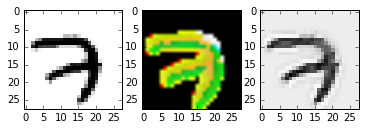

In [5]:
plt.subplot(1,3,1)
imshow(test_img.eval()[0,...].reshape([1,28,28,1]))
plt.subplot(1,3,2)
plt.imshow(conv.eval()[0,...].reshape([28,28,3]))
plt.subplot(1,3,3)
imshow(deconv.eval()[0,...].reshape([1,28,28,1]))

In [6]:
maxpool, argmax = tf.nn.max_pool_with_argmax(conv,
                                             ksize=[1,2,2,1],
                                             strides=[1,2,2,1],
                                            padding='SAME')

In [7]:
maxshape = [s.value for s in maxpool.get_shape()]
offset = tf.cast(28 * 28 * 3, tf.int64)
batch_mul = tf.mul(offset, tf.reshape(tf.cast(tf.range(0,5), tf.int64),[5,1,1,1]))
batch_argmax = tf.add(batch_mul, argmax)
maxflat = tf.reshape(maxpool, [-1])
argflat = tf.reshape(batch_argmax, [-1])
sparse = tf.sparse_to_dense(argflat, [BATCH_SIZE*28*28*3], maxflat, validate_indices=False)
reshaped = tf.reshape(sparse, [-1,28,28,3])

In [8]:
deconv_unpool = tf.nn.conv2d_transpose(reshaped, filt, [BATCH_SIZE,28,28,1], [1,1,1,1])

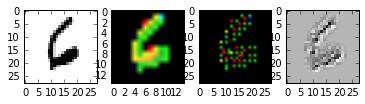

In [11]:
im_n = 3

plt.subplot(1,4,1)
imshow(test_img.eval()[im_n,...].reshape([1,28,28,1]))
plt.subplot(1,4,2)
plt.imshow(maxpool.eval()[im_n,...].reshape([14,14,3]))
plt.subplot(1,4,3)
plt.imshow(reshaped.eval()[im_n,...].reshape([28,28,3]))
plt.subplot(1,4,4)
imshow(deconv_unpool.eval()[im_n,...].reshape([1,28,28,1]))

## What didn't work

In [32]:
test_batch = tf.reshape(mnist.train.next_batch(2)[0], [2,28,28,1])

In [95]:
maxpool, argmax = tf.nn.max_pool_with_argmax(test_batch,
                                             ksize=[1,2,2,1],
                                             strides=[1,2,2,1],
                                            padding='SAME')

In [43]:
maxflat = tf.reshape(maxpool, [-1])
argflat = tf.reshape(argmax, [-1])
sparse = tf.sparse_to_dense(argflat, [1568], maxflat, validate_indices=False)
reshaped = tf.reshape(sparse, [-1,28,28,1])

#sparse = tf.SparseTensorValue(argflat,maxflat,[-1,196])
#dense = tf.sparse_tensor_to_dense(sparse, validate_indices=False)
#reshape = tf.reshape(dense, [-1,28,28,1])

In [91]:
max_batch = tf.unpack(maxpool)

In [93]:
max_batch[0].get_shape().as_list()

[14, 14, 1]

In [69]:
argmax32 = tf.reshape(tf.cast(argmax, dtype=tf.int32), [2,-1])
batch_rescale = tf.cast(tf.range(1,3), dtype=tf.int32)

tf.matmul(argmax32, batch_rescale)

ValueError: Shape (2,) must have rank 2

In [70]:
batch_rescale.get_shape().as_list()

[2]

ValueError: total size of new array must be unchanged

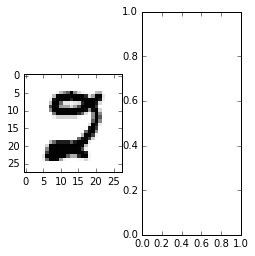

In [31]:
plt.subplot(1,3,1)
imshow(test_batch.eval()[1,:,:,:].reshape([1,28,28,1]))
plt.subplot(1,3,2)
imshow(maxpool.eval()[1,:,:,:].reshape([1,14,14,1]))
plt.subplot(1,3,3)
imshow(reshaped.eval()[1,:,:,:].reshape([1,28,28,1]))

## Gradient experiments

In [10]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
@ops.RegisterGradient("MaxPoolWithArgmax")
def _MaxPoolGrad(op, grad):
  return gen_nn_ops._max_pool_grad(op.inputs[0],
                                   op.outputs[0],
                                   grad,
                                   op.get_attr("ksize"),
                                   op.get_attr("strides"),
                                   padding=op.get_attr("padding"),
                                   data_format=op.get_attr("data_format"))